## 1. Defining the Problem and Assembling a Dataset

**Problem:** Classify tweets into 4 sentiment categories with focus on systematic hyperparameter tuning.

<a href="https://colab.research.google.com/github/sreent/machine-learning/blob/main/Final%20DNN%20Code%20Examples/Twitter%20Sentiment%20Grid%20Search/Twitter%20Sentiment%20Analysis%20-%20Grid%20Search%20on%20Model%20and%20its%20Settings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Sentiment Analysis - Grid Search on Model and its Settings

This notebook demonstrates **comprehensive grid search** for hyperparameter tuning, comparing different model architectures systematically.

## Learning Objectives

By the end of this notebook, you will be able to:
- Design and execute a comprehensive **grid search** over model architectures
- Compare different regularization strategies: **Dropout vs. L2 regularization**
- Search across multiple dimensions: depth, width, dropout rate, learning rate
- Interpret grid search results to select optimal model configurations

---

## Dataset Overview

| Attribute | Description |
|-----------|-------------|
| **Source** | [Kaggle Twitter Sentiment](https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis) |
| **Problem Type** | Multi-Class Classification (4 classes) |
| **Classes** | Irrelevant, Negative, Neutral, Positive |
| **Data Balance** | Imbalanced |
| **Input Features** | TF-IDF Vectors (2500 features, bigrams) |

---

## Grid Search Strategy

This notebook compares:
- **Model Architectures:** Single layer (deep), Wide single layer (wider), Two layers (deeper)
- **Regularization:** Dropout (0.25, 0.5) vs. L2 weight decay
- **Learning Rates:** 0.0025, 0.005
- **Batch Sizes:** 512

---

## 2. Choosing a Measure of Success

Precision, Recall, and AUC for imbalanced multi-class classification.

## 3. Deciding on an Evaluation Protocol

K-Fold Cross-Validation (K=5) is crucial for reliable grid search results.

## 4. Preparing Your Data

### 4.1 Import Libraries and Load Dataset

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

import keras
import tensorflow
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import Precision, Recall, AUC
from keras.utils import np_utils
from keras.models import Sequential, clone_model
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from tensorflow.keras import layers

# Keras Tuner for hyperparameter search
!pip install -q -U keras-tuner
import keras_tuner as kt

import itertools
import matplotlib.pyplot as plt

SEED = 204

tensorflow.random.set_seed(SEED)
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

FILE_PATH = 'twitter.csv'

In [2]:
tweets = pd.read_csv(FILE_PATH, sep=',', header=None)

tweets = tweets[[2, 3]]
tweets.columns = ['sentiment', 'text']

tweets.dropna(inplace=True)

tweets.head()

,sentiment,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [3]:
TEST_SIZE = 0.1

(tweets_train, tweets_test, 
 sentiment_train, sentiment_test) = train_test_split(tweets['text'], tweets['sentiment'], 
                                                     test_size=TEST_SIZE, stratify=tweets['sentiment'],
                                                     shuffle=True, random_state=SEED)

In [4]:
MAX_FEATURES = 2500
NGRAMS = 2

tfidf = TfidfVectorizer(ngram_range=(1, NGRAMS), max_features=MAX_FEATURES)
tfidf.fit(tweets_train)

X_train, X_test = tfidf.transform(tweets_train).toarray(), tfidf.transform(tweets_test).toarray()

In [5]:
label_encoder = LabelEncoder()
label_encoder.fit(tweets['sentiment'])

y_train = np_utils.to_categorical(label_encoder.transform(sentiment_train))
y_test = np_utils.to_categorical(label_encoder.transform(sentiment_test))

In [6]:
VALIDATION_SIZE = X_test.shape[0]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                 test_size=VALIDATION_SIZE, stratify=y_train,
                                                 shuffle=True, random_state=SEED)

## 5. Developing a Model That Does Better Than a Baseline

Naive baseline: ~30% (majority class - Negative).

In [7]:
counts = tweets.groupby(['sentiment']).count()
counts.reset_index(inplace=True)

counts

,sentiment,text
0,Irrelevant,12875
1,Negative,22358
2,Neutral,18108
3,Positive,20655


In [8]:
naive_baseline = counts[counts['sentiment']=='Negative']['text'].values[0] / counts['text'].sum()

naive_baseline

0.3021514676468998

In [9]:
labels = np.argmax(y_train, axis=1)
weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
CLASS_WEIGHT = dict(enumerate(weights))

CLASS_WEIGHT

{0: 1.4367961165048544,
 1: 0.8274069104327407,
 2: 1.0216070688941046,
 3: 0.8956063907044299}

In [ ]:
INPUT_DIMENSION = X_train.shape[1]
OUTPUT_CLASSES = y_train.shape[1]

OPTIMIZER = 'rmsprop'
LOSS_FUNC = 'categorical_crossentropy'
METRICS = ['categorical_accuracy', 
           Precision(name='precision'), 
           Recall(name='recall'),
           AUC(name='auc', multi_label=True)]

In [11]:
baseline = Sequential(
    [
        Dense(OUTPUT_CLASSES, activation='softmax', input_shape=(INPUT_DIMENSION,))
    ]
)

baseline._name = 'baseline'
baseline_initial_weights = baseline.get_weights()

baseline.summary()

Model: "baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 10004     
                                                                 
Total params: 10,004
Trainable params: 10,004
Non-trainable params: 0
_________________________________________________________________


In [12]:
learning_rate = 0.01

baseline.compile(optimizer=RMSprop(learning_rate=learning_rate), 
                 loss=LOSS_FUNC, metrics=METRICS)

In [13]:
EPOCHS = 100
batch_size=512

baseline.set_weights(baseline_initial_weights)

baseline_history = baseline.fit(X_train, y_train,
                                class_weight=CLASS_WEIGHT,
                                batch_size=batch_size, epochs=EPOCHS, 
                                validation_data=(X_val, y_val),
                                callbacks=[EARLY_STOP],
                                verbose=0)

2023-03-09 10:29:59.695765: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 591960000 exceeds 10% of free system memory.


In [14]:
baseline_scores = baseline.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline={:.2f})'.format(baseline_scores[0], naive_baseline))
print('Precision (Validation): {:.2f}'.format(baseline_scores[1]))
print('Recall (Validation): {:.2f}'.format(baseline_scores[2]))
print('AUC (Validation): {:.2f}'.format(baseline_scores[3]))

Accuracy (Validation): 0.63 (Naive Baseline=0.30)
Precision (Validation): 0.72
Recall (Validation): 0.53
AUC (Validation): 0.86


In [15]:
def plot_training_history(history, monitor='loss') :
    loss, val_loss = history.history[monitor], history.history['val_' + monitor]

    epochs = range(1, len(loss)+1)

    plt.plot(epochs, loss, 'b.', label=monitor)
    plt.plot(epochs, val_loss, 'r.', label='Validation ' + monitor)
    plt.xlim([0, len(loss)])
    plt.title('Training and Validation ' + monitor + 's')
    plt.xlabel('Epochs')
    plt.ylabel(monitor)
    plt.legend()
    plt.grid()
    _ = plt.show()

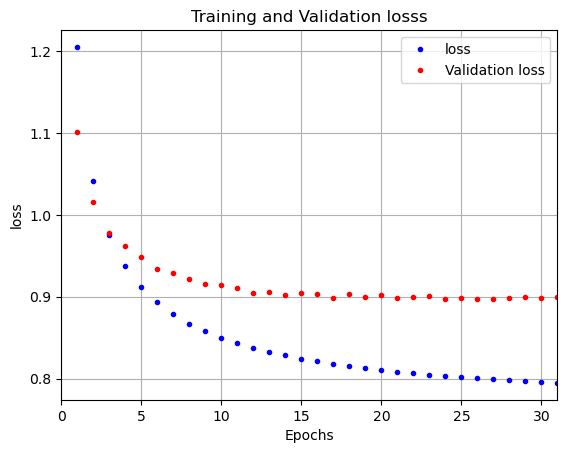

In [16]:
plot_training_history(baseline_history, monitor='loss')

## 6. Scaling Up: Developing a Model That Overfits

Building a model with enough capacity to overfit the training data.

In [27]:

overfit = Sequential(
    [
        Dense(64, activation='relu', input_shape=(INPUT_DIMENSION,)),
        Dense(OUTPUT_CLASSES, activation='softmax')
    ]
)

overfit_initial_weights = overfit.get_weights()
overfit._name = 'overfit'

overfit.summary()

Model: "overfit"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                160064    
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 160,324
Trainable params: 160,324
Non-trainable params: 0
_________________________________________________________________


In [28]:
learning_rate = 0.0025

overfit.compile(optimizer=RMSprop(learning_rate=learning_rate), 
                loss=LOSS_FUNC, metrics=METRICS)

overfit.set_weights(overfit_initial_weights)

In [29]:
EPOCHS = 100
batch_size=512

overfit.set_weights(overfit_initial_weights)

overfit_history = overfit.fit(X_train, y_train,
                              class_weight=CLASS_WEIGHT,
                              batch_size=batch_size, epochs=EPOCHS, 
                              validation_data=(X_val, y_val),
                              callbacks=[],
                              verbose=0)

2023-03-08 06:53:40.326486: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 591960000 exceeds 10% of free system memory.


In [30]:
overfit_scores = overfit.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline = {:.2f})'.format(overfit_scores[0], naive_baseline))
print('Precision (Validation): {:.2f}'.format(overfit_scores[1]))
print('Recall (Validation): {:.2f}'.format(overfit_scores[2]))
print('AUC (Validation): {:.2f}'.format(overfit_scores[3]))

Accuracy (Validation): 0.84 (Naive Baseline = 0.30)
Precision (Validation): 0.87
Recall (Validation): 0.83
AUC (Validation): 0.96


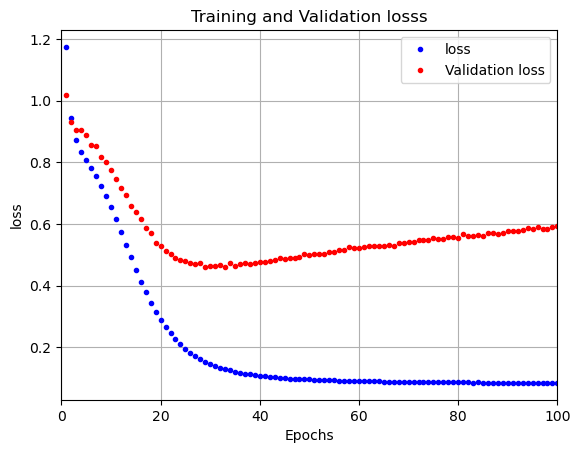

In [31]:
plot_training_history(overfit_history, monitor='loss')

## 7. Regularizing Your Model and Tuning Hyperparameters

Using **Hyperband** for efficient hyperparameter tuning with a frozen architecture.

### Why Hyperband?

**Hyperband** is more efficient than grid search because it:
1. Starts training many configurations for a few epochs
2. Eliminates poor performers early
3. Allocates more resources to promising configurations

In [ ]:
# Hyperband Model Builder for Multi-Class Twitter Classification
def build_model_hyperband(hp):
    """
    Build Twitter Sentiment model with FROZEN architecture (2 layers: 128 -> 64 neurons).
    Only tunes regularization (Dropout) and learning rate.
    """
    model = keras.Sequential()
    model.add(layers.Input(shape=(INPUT_DIMENSION,)))

    # Fixed architecture: 2 hidden layers with 128 and 64 neurons
    # Layer 1: 128 neurons
    model.add(layers.Dense(128, activation='relu'))
    drop_0 = hp.Float('drop_0', 0.0, 0.5, step=0.1)
    model.add(layers.Dropout(drop_0))

    # Layer 2: 64 neurons
    model.add(layers.Dense(64, activation='relu'))
    drop_1 = hp.Float('drop_1', 0.0, 0.5, step=0.1)
    model.add(layers.Dropout(drop_1))

    # Output layer for multi-class classification
    model.add(layers.Dense(OUTPUT_CLASSES, activation='softmax'))

    lr = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=LOSS_FUNC,
        metrics=METRICS
    )
    return model

In [ ]:
# Configure Hyperband tuner
tuner = kt.Hyperband(
    build_model_hyperband,
    objective='val_auc',
    max_epochs=20,
    factor=3,
    directory='twitter_sentiment_hyperband',
    project_name='twitter_sentiment_tuning'
)

# Run Hyperband search
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=512,
    class_weight=CLASS_WEIGHT
)

In [35]:
def cross_validation(X, y,
                     class_weight,
                     params, kfolds, epochs,
                     callbacks, seed=0) :
    evaluations = []
    for train, validate in kfolds.split(X, y.argmax(axis=1)) :
        model = clone_model(params['model'])
        
        for layer in model.layers :
            if type(layer) == keras.layers.regularization.dropout.Dropout :
                layer.rate = params['dropout']
        
        model.compile(optimizer=RMSprop(learning_rate=params['learning_rate']), 
                      loss=LOSS_FUNC, metrics=METRICS)
        
        history = model.fit(X[train,:], y[train,:],
                            class_weight=class_weight,
                            batch_size=params['batch_size'], epochs=epochs, 
                            validation_data=(X[validate,:], y[validate,:]),
                            callbacks=callbacks,
                            verbose=0)
        
        evaluation = model.evaluate(X_val, y_val, verbose=0)[1:]
        evaluations.append( evaluation )
        
    return np.mean(evaluations, axis=0)

In [38]:
# our search space
params = {
    'model': [deep, wider, deeper],
    'dropout': [0.25, 0.5],
    'learning_rate': [0.0025, 0.005],
    'batch_size': [512]
}

EPOCHS = 500
KFOLDS = 5

In [40]:
def dict_to_dataframe(stats) :
    entries = []
    for key, value in stats.items() :
        entry = eval(key)
        
        metrics = ['accuracy', 'precision', 'recall', 'auc']
        for metric, score in zip(metrics, value) :
            entry[metric] = score

        entries.append(entry)

    return pd.DataFrame(entries)

In [37]:
# the best parameters by AUC are:
# model = wider
# dropout = 0.25
# learning_rate = 0.005
# batch_size = 512

In [43]:
validation_scores = best_model.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline = {:.2f})'.format(validation_scores[0], naive_baseline))
print('Precision (Validation): {:.2f}'.format(validation_scores[1]))
print('Recall (Validation): {:.2f}'.format(validation_scores[2]))
print('AUC (Validation): {:.2f}'.format(validation_scores[3]))

Accuracy (Validation): 0.86 (Naive Baseline = 0.30)
Precision (Validation): 0.90
Recall (Validation): 0.83
AUC (Validation): 0.97


In [45]:
test_scores = best_model.evaluate(X_test, y_test, verbose=0)[1:]

print('Accuracy (Test): {:.2f} (Naive Baseline = {:.2f})'.format(test_scores[0], naive_baseline))
print('Precision (Test): {:.2f}'.format(test_scores[1]))
print('Recall (Test): {:.2f}'.format(test_scores[2]))
print('AUC (Test): {:.2f}'.format(test_scores[3]))

Accuracy (Validation): 0.85 (Naive Baseline = 0.30)
Precision (Validation): 0.90
Recall (Validation): 0.83
AUC (Validation): 0.97


In [37]:
l2exp.compile(optimizer=RMSprop(learning_rate=best_params['learning_rate']), 
              loss=LOSS_FUNC, metrics=METRICS)
        
l2exp_history = l2exp.fit(X_train, y_train,
                          class_weight=CLASS_WEIGHT,
                          batch_size=best_params['batch_size'], epochs=EPOCHS, 
                          validation_data=(X_val, y_val),
                          callbacks=[EARLY_STOP],
                          verbose=0)

2023-03-09 11:03:57.924888: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 591960000 exceeds 10% of free system memory.


In [39]:
validation_scores = l2exp.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline = {:.2f})'.format(validation_scores[0], naive_baseline))
print('Precision (Validation): {:.2f}'.format(validation_scores[1]))
print('Recall (Validation): {:.2f}'.format(validation_scores[2]))
print('AUC (Validation): {:.2f}'.format(validation_scores[3]))

Accuracy (Validation): 0.82 (Naive Baseline = 0.30)
Precision (Validation): 0.88
Recall (Validation): 0.76
AUC (Validation): 0.96


In [ ]:
# Get best hyperparameters and build best model
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print(f"  Dropout Layer 1: {best_hp.get('drop_0')}")
print(f"  Dropout Layer 2: {best_hp.get('drop_1')}")
print(f"  Learning Rate: {best_hp.get('lr')}")

best_model = tuner.hypermodel.build(best_hp)
best_model.summary()

In [ ]:
# Train the best model
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=512,
    class_weight=CLASS_WEIGHT,
    verbose=1
)

validation_scores = best_model.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline = {:.2f})'.format(validation_scores[0], naive_baseline))
print('Precision (Validation): {:.2f}'.format(validation_scores[1]))
print('Recall (Validation): {:.2f}'.format(validation_scores[2]))
print('AUC (Validation): {:.2f}'.format(validation_scores[3]))